# Quality Control

## Environment setup and data

In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
import pandas as pd
from scipy.stats import median_abs_deviation
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import os
os.chdir("/data/home/wx/") 

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

/tmp/ipykernel_2114816/1036419750.py:15: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
%%R
inputdir<-c('scislets/data/ZP/output')
outputdir<-c('scislets/data/ZP/output/h5ad')
library(Seurat)
library(MuDataSeurat)
data <- Read10X(data.dir = paste0(inputdir,'/','filter_matrix'), gene.colum=1)
data <- CreateSeuratObject(counts = data, min.cells = 0, min.features = 0, project = "DMSO")
MuDataSeurat::WriteH5AD(data, paste0(outputdir,'/','filter.h5ad'), assay="RNA")
data.raw<-Read10X(data.dir = paste0(inputdir,'/','raw_matrix'), gene.colum=1)
data.raw <- CreateSeuratObject(counts = data.raw, min.cells = 0, min.features = 0, project = "DMSO")
MuDataSeurat::WriteH5AD(data.raw, paste0(outputdir,'/','raw.h5ad'), assay="RNA")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Attaching SeuratObject


In [3]:
adata = sc.read_h5ad(
    filename='scislets/data/ZP/output/h5ad/filter.h5ad'
)
adata

AnnData object with n_obs × n_vars = 6837 × 32779
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA'
    layers: 'counts'

In [4]:
adata.var_names_make_unique()

## Filtering low quality reads

In [5]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

In [7]:
#Basic filtering: 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

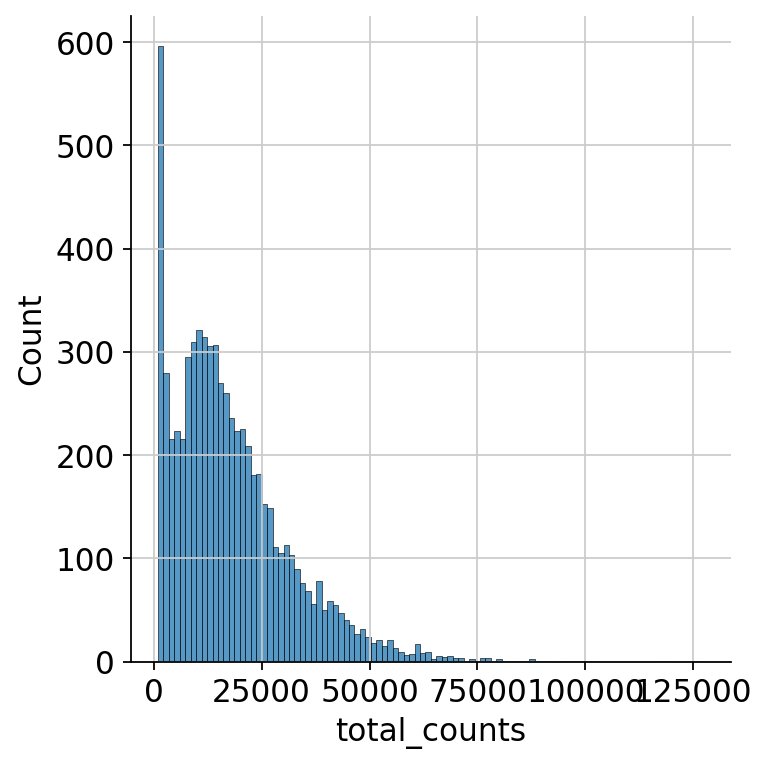

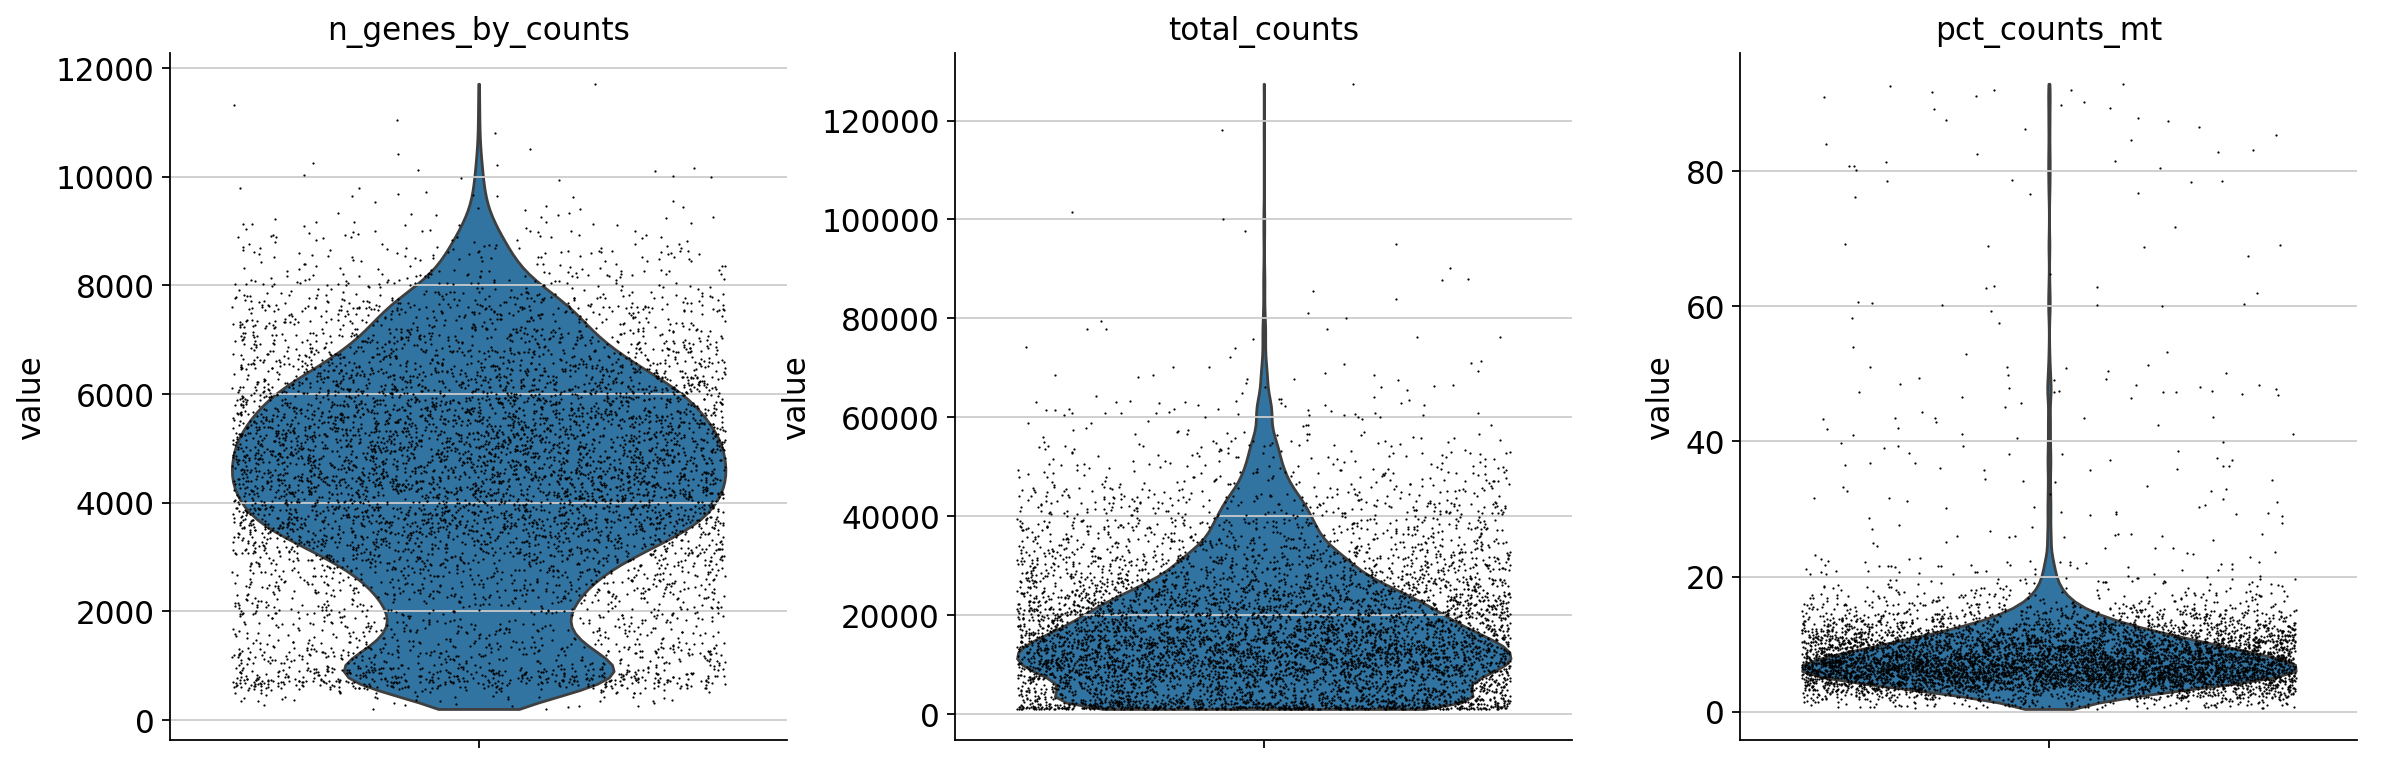

/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


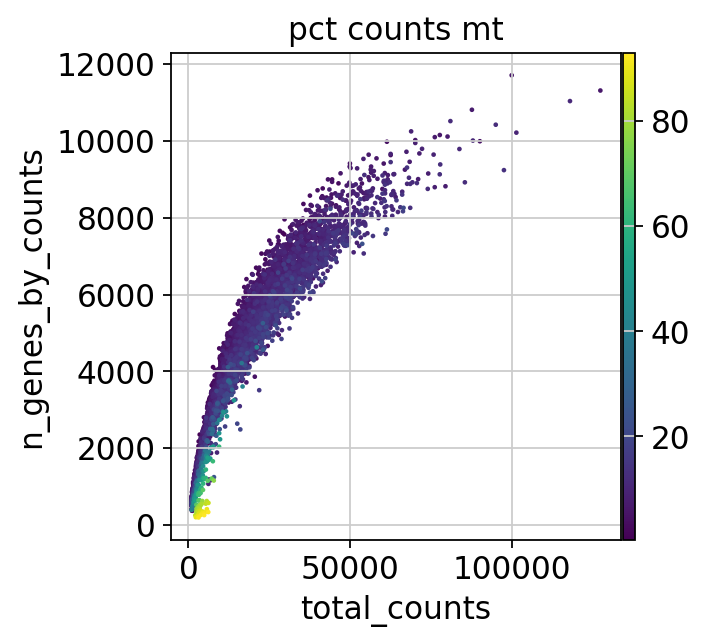

In [8]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True)
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [9]:
#Basic filtering:
adata = adata[adata.obs.n_genes_by_counts < 11000, :]
adata = adata[adata.obs.n_genes_by_counts > 1500, :]
#adata = adata[adata.obs.total_counts > 2000, :]

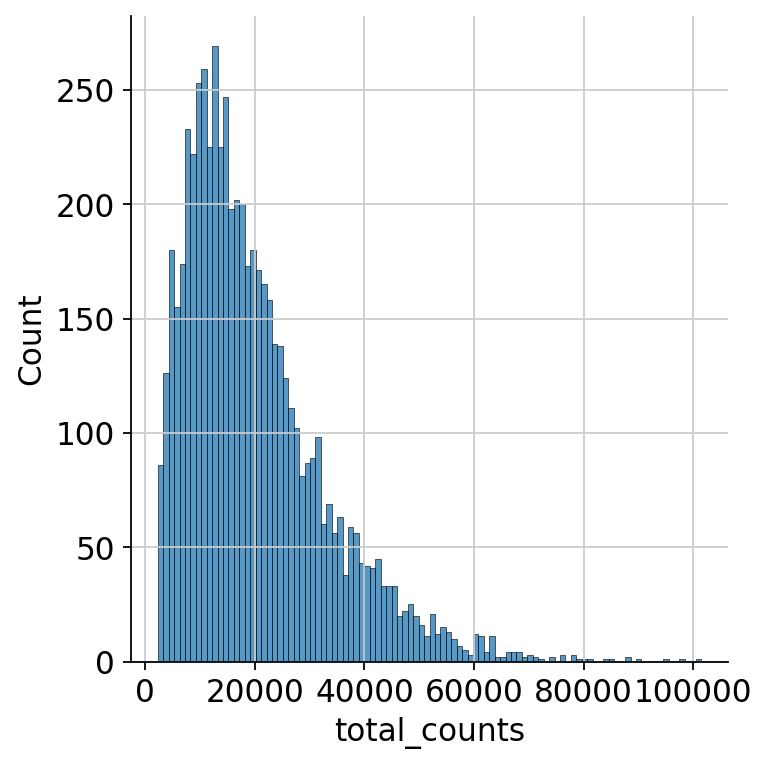

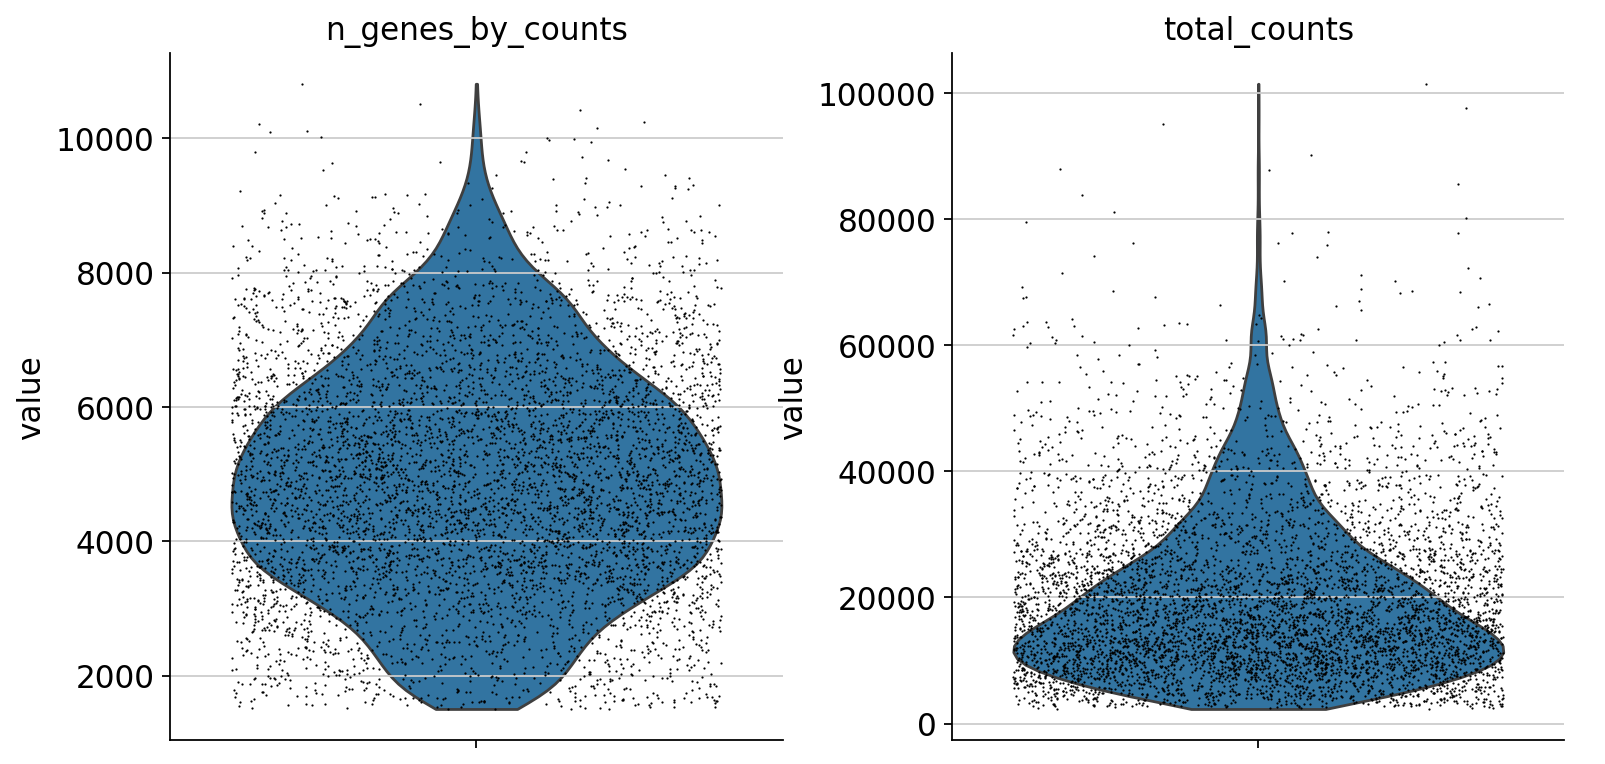

/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


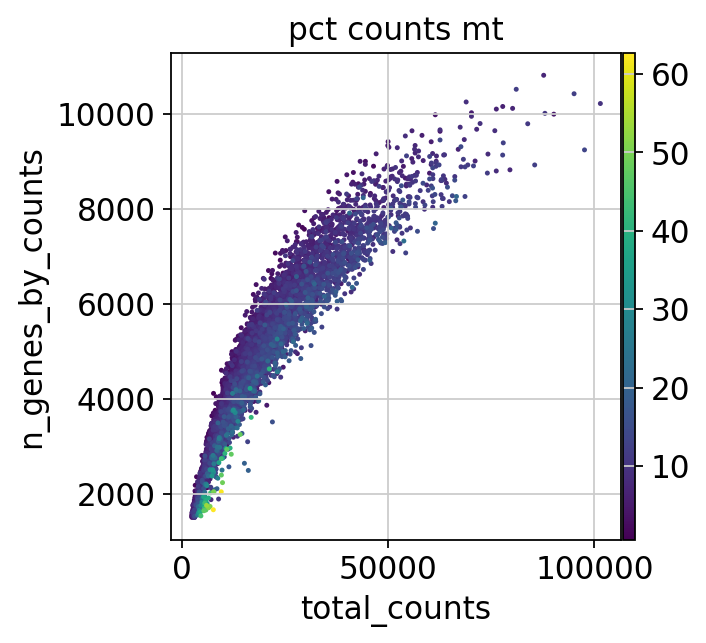

In [10]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [11]:
#filter
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

/tmp/ipykernel_2114816/3121625339.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["outlier"] = (


outlier
False    6004
True       18
Name: count, dtype: int64

In [12]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    3291
True     2731
Name: count, dtype: int64

In [13]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 6022
Number of cells after filtering of low quality cells: 3289


/data/home/wx/miniconda3/envs/scislets/lib/python3.9/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


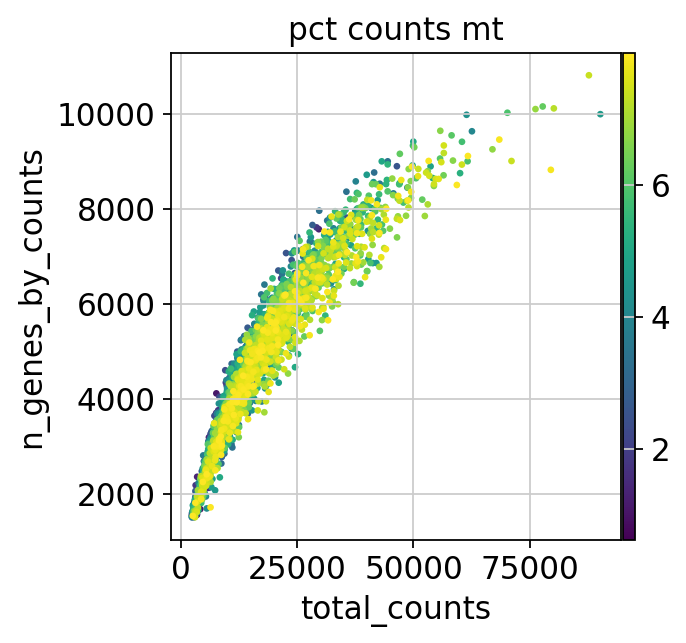

In [14]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Correction of ambient RNA

In [15]:
%%R
library(SoupX)

In [16]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

In [17]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

2024-03-14 16:31:49.093473: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 16:31:49.132020: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 16:31:49.778160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
del adata_pp

In [19]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [20]:
data

<29533x3289 sparse matrix of type '<class 'numpy.float64'>'
	with 15350414 stored elements in Compressed Sparse Column format>

In [21]:
adata_raw = sc.read_h5ad(
    filename="scislets/data/ZP/output/h5ad/raw.h5ad"
)
adata_raw.var_names_make_unique()
cells_raw = adata_raw.obs_names
genes_raw = adata_raw.var_names
data_tod = adata_raw.X.T


In [22]:
del adata_raw

In [23]:
%%R -i data -i data_tod -i genes -i cells  -i genes_raw -i cells_raw -i soupx_groups -o out

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
rownames(data_tod) = genes_raw
colnames(data_tod) = cells_raw
data_tod <- data_tod[rownames(data),]
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")
#data_tod <- subset(data_tod,rownames(data_tod) %in% rownames(data))
# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

466 genes passed tf-idf cut-off and 3 soup quantile filter.  Taking the top 3.
Using 10 independent estimates of rho.
Estimated global rho of 0.01
Expanding counts from 14 clusters to 3289 cells.
In addition: Warning messages:
1: In autoEstCont(sc, doPlot = FALSE) :
  Fewer than 10 marker genes found.  Is this channel low complexity (see help)?  If not, consider reducing tfidfMin or soupQuantile
2: In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


In [24]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

Next, we additionally filter out genes that are not detected in at least 20 cells as these are not informative.

In [25]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 29533
Number of genes after cell filter: 20099


(rna:doublet-detection)=
## Doublet Detection

In [26]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [27]:
data_mat = adata.X.T

In [28]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~2632 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 328 cells excluded from training.
iter=1, 388 cells excluded from training.
iter=2, 406 cells excluded from training.
Threshold found:0.736
241 (7.3%) doublets called


In [29]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    3048
doublet     241
Name: count, dtype: int64

In [30]:
adata=adata[adata.obs.scDblFinder_class=="singlet", :]

In [31]:
adata.obs.scDblFinder_class

CELL9_N2        singlet
CELL12_N2       singlet
CELL17_N2       singlet
CELL20_N2       singlet
CELL22_N2       singlet
                 ...   
CELL99560_N1    singlet
CELL99583_N1    singlet
CELL99599_N1    singlet
CELL99702_N1    singlet
CELL99752_N1    singlet
Name: scDblFinder_class, Length: 3048, dtype: category
Categories (1, object): ['singlet']

In [32]:
adata.write("scislets/processed/ZP_quality_control.h5ad")

## Key Takeaways

1. Filtering of poor-quality cells should be based on median absolute deviations with lenient cutoffs to avoid bias against smaller subpopulations.
2. Feature-based filtering does not show benefits for downstream tasks. 
3. Doublets can be efficiently detected with tools like scDblFinder. 
4. Doublet detection methods should not be run on aggregated scRNA-seq data representing multiple batches. 

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: qc
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Anna Schaar

### Reviewers

* Lukas Heumos
